# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, min, max, split, stddev, udf, col, concat, count, desc, explode, lit
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier

In [3]:
# create a Spark session
spark_session = SparkSession.builder.master('local').appName('sparkify').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
path = 'mini_sparkify_event_data.json'
df = spark_session.read.json(path)

In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
print(df.count())

286500


In [7]:
len(df.columns)

18

In [8]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [9]:
# check for empty session id
session_id = df.toPandas()['sessionId'].unique().tolist()

print( np.sum(np.array(session_id) == ''), np.sum(np.array(session_id) == None))

0 0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  after removing the cwd from sys.path.


In [10]:
# drop row with empty userId or session_id
df_clean = df.dropna(how='any', subset=['userId', 'sessionId'])
df_clean = df.toPandas()

df_clean = df_clean[df_clean['userId'] != ""]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
# extract userId with 'Submit Downgrade' and 'Cancellation Confirmation'
users_churned = df_clean[(df_clean['page'] == 'Submit Downgrade') | (df_clean['page'] == 'Cancellation Confirmation')]
users_churned = users_churned['userId'].unique()
users_churned

array(['131', '38', '141', '18', '30', '20', '32', '12', '11', '61', '81',
       '125', '85', '140', '105', '17', '35', '143', '54', '77', '59',
       '103', '95', '101', '129', '121', '51', '87', '122', '58', '74',
       '73', '9', '24', '3', '106', '39', '100', '28', '13', '96', '25',
       '109', '49', '29', '70', '53', '92', '100011', '100001', '100024',
       '100006', '100019', '100018', '100003', '100023', '100015',
       '100004', '100025', '100005', '100012', '100017', '100009',
       '100013', '100022', '100014', '100008', '100016', '100021',
       '100007', '200003', '200023', '200025', '200001', '200024',
       '200019', '200020', '200009', '200011', '200021', '200018',
       '200015', '200017', '200016', '300007', '300015', '300021',
       '300002', '300011', '300004', '300001', '300023'], dtype=object)

In [12]:
df_clean['churned'] = df_clean['userId'].apply(lambda x: 1 if x in users_churned else 0)
df_clean.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churned
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,1
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,1
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,1
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,1
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,1


In [13]:
# data exploration
df_clean.describe()

,itemInSession,length,registration,sessionId,status,ts,churned
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05,278154.000000
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12,0.504810
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09,0.499978
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12,0.000000
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12,0.000000
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12,1.000000
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12,1.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12,1.000000


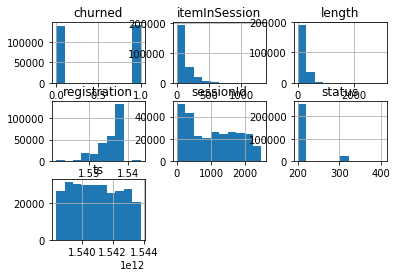

In [14]:
df_clean.hist();

In [15]:
df_clean.page.unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
       'Add Friend', 'Settings', 'Submit Upgrade', 'About',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation'], dtype=object)

In [16]:
df_clean.level.unique()

array(['paid', 'free'], dtype=object)

In [17]:
df_grouped = df_clean.groupby(['userId', 'gender', 'churned']).count().reset_index()[['userId', 'gender', 'churned']]
df_grouped.head()

,userId,gender,churned
0,10,M,0
1,100,M,1
2,100001,F,1
3,100002,F,0
4,100003,F,1


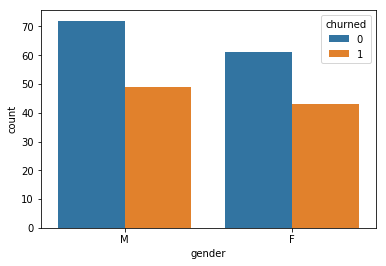

In [18]:
sns.countplot(x='gender', hue='churned', data=df_grouped)

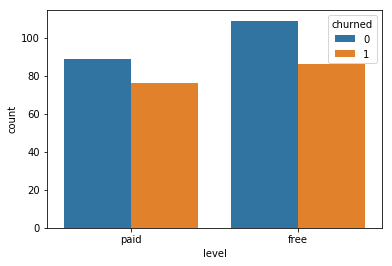

In [19]:
df_grouped = df_clean.groupby(['userId', 'level', 'churned']).count().reset_index()[['userId', 'level', 'churned']]
sns.countplot(x='level', hue='churned', data=df_grouped)

In [20]:
df_session = df.dropna(how='any', subset=['userId', 'sessionId'])
df_session = df_session.filter(df['userId'] != '')

df_session.createOrReplaceTempView("sparkify")

In [21]:
df_session.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
# for each user, count...
## number of thumbs down
## number of thumbs up
## number of errors
## number of add to playlist
## number of add friends
## number of total songs played
## also add churn column...

query = '''
        SELECT userId
             , COUNT(CASE WHEN page = 'Thumbs Down' THEN userId END) AS thumbs_down_cnt
             , COUNT(CASE WHEN page = 'Thumbs Up' THEN userId END) AS thumbs_up_cnt
             , COUNT(CASE WHEN page = 'Error' THEN userId END) AS error_cnt
             , COUNT(CASE WHEN page = 'Add to Playlist' THEN userId END) AS add_list_cnt
             , COUNT(CASE WHEN page = 'Add Friend' THEN userId END) AS add_friend_cnt
             , COUNT(*) AS total_songs
             , MAX(CASE WHEN page = 'Submit Downgrade' OR page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS churned
        FROM sparkify
        GROUP BY userId
'''

In [23]:
df_query = spark_session.sql(query)

In [24]:
df_result = df_query.toPandas()
df_result.head()

,userId,thumbs_down_cnt,thumbs_up_cnt,error_cnt,add_list_cnt,add_friend_cnt,total_songs,churned
0,100010,5,17,0,7,4,381,0
1,200002,6,21,0,8,4,474,0
2,125,0,0,0,0,0,11,1
3,51,21,100,1,52,28,2464,1
4,124,41,171,6,118,74,4825,0


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


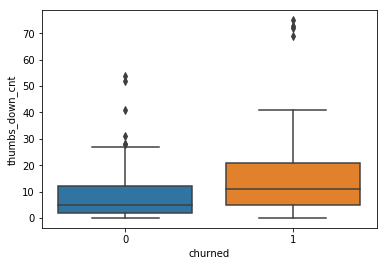

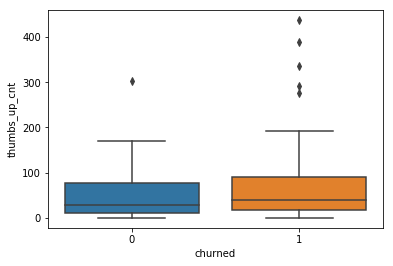

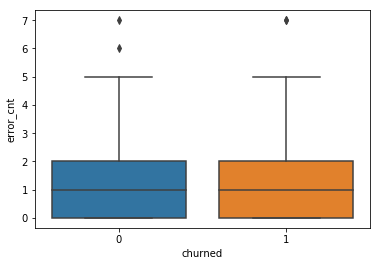

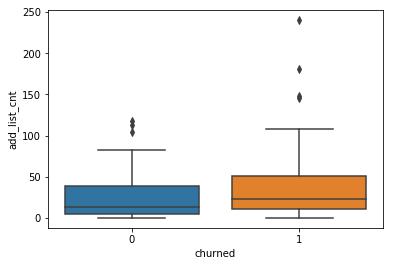

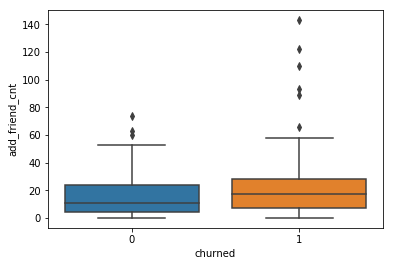

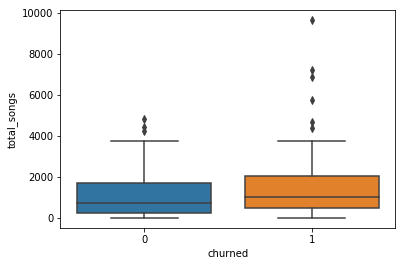

In [25]:
for col in df_result.columns.values[1:-1]:
    fig = plt.figure()
    sns.boxplot(x='churned', y=col, data = df_result)
    fig.show();
    

- Thumbs down count : user who churned has more thumbs down
- Thumbs up count : user who churned has slight more thumbs up
- error count : both user had similar error count
- add to playlist count: user who churned has added to playlist slightly more
- add friend count: user who churned has slightly more friends added
- total song: user who churned has slightly more songs played

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [26]:
query = '''
        SELECT userId
             , COUNT(CASE WHEN page = 'Thumbs Down' THEN userId END) AS thumbs_down_cnt
             , COUNT(CASE WHEN page = 'Thumbs Up' THEN userId END) AS thumbs_up_cnt
             , COUNT(CASE WHEN page = 'Error' THEN userId END) AS error_cnt
             , COUNT(CASE WHEN page = 'Add to Playlist' THEN userId END) AS add_list_cnt
             , COUNT(CASE WHEN page = 'Add Friend' THEN userId END) AS add_friend_cnt
             , COUNT(*) AS total_songs
             , MAX(CASE WHEN page = 'Submit Downgrade' OR page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS label
        FROM sparkify
        GROUP BY userId
'''

In [27]:
df_query = spark_session.sql(query)

In [28]:
train_set, test_set = df_query.randomSplit([0.8, 0.2], seed=42)

In [29]:
cols = df_query.columns[1:-1]

assembler = VectorAssembler(inputCols=cols, outputCol="features")
minmaxscaler = MinMaxScaler(inputCol='features', outputCol='features_scaled')

In [30]:
# Try random Forest
randomforest = RandomForestClassifier(labelCol='label', featuresCol="features_scaled", numTrees=5)
pipeline_randomforest = Pipeline(stages=[assembler, minmaxscaler, randomforest])

paramgrid = ParamGridBuilder().addGrid(randomforest.numTrees, [3, 5, 10]).build()

crossval_randomforest = CrossValidator(estimator=pipeline_randomforest,
                                       estimatorParamMaps=paramgrid,
                                       evaluator=MulticlassClassificationEvaluator(),
                                       numFolds=3
                                       )


In [31]:
model_randomforest = crossval_randomforest.fit(train_set)
model_randomforest.avgMetrics

[0.5426202670406316, 0.6069431993167917, 0.600274981532097]

In [32]:
results_randomforest = model_randomforest.transform(test_set)
print('accuracy :', results_randomforest.filter(results_randomforest.label == results_randomforest.prediction).count() / results_randomforest.count())

accuracy : 0.6176470588235294


In [33]:
f1 = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1.evaluate(results_randomforest)
f1_score

0.6208481532147743

In [34]:
model_randomforest.bestModel.stages[-1]._java_obj.parent().getNumTrees()

5

In [35]:
### Gradient Boosting

gb = GBTClassifier(labelCol='label', featuresCol="features_scaled", maxIter=10)
pipeline_gb = Pipeline(stages=[assembler, minmaxscaler, gb])

paramgrid = ParamGridBuilder().addGrid(gb.maxIter, [3, 5, 10]).build()

crossval_gb = CrossValidator(estimator=pipeline_gb,
                                       estimatorParamMaps=paramgrid,
                                       evaluator=MulticlassClassificationEvaluator(),
                                       numFolds=3,
                                       collectSubModels=True
                                       )

model_gb = crossval_gb.fit(train_set)
model_gb.avgMetrics

[0.6344965546283371, 0.6125468544730913, 0.6041665056630382]

In [36]:
results_gb = model_gb.transform(test_set)
print('accuracy :', results_gb.filter(results_gb.label == results_gb.prediction).count() / results_gb.count())

accuracy : 0.6176470588235294


In [37]:
f1 = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1.evaluate(results_gb)
f1_score

0.6208481532147743

In [38]:
## Logistic Regression

logreg =  LogisticRegression(labelCol="label", featuresCol="features_scaled", maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline_lr = Pipeline(stages=[assembler, minmaxscaler, logreg])

paramgrid = ParamGridBuilder().addGrid(logreg.regParam,[0.0, 0.1]).build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramgrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [39]:
model_lr = crossval_lr.fit(train_set)
model_lr.avgMetrics

[0.5586688946348144, 0.5121782802259781]

In [40]:
results_lr = model_lr.transform(test_set)
print('accuracy :', results_lr.filter(results_lr.label == results_lr.prediction).count() / results_lr.count())

accuracy : 0.6470588235294118


In [41]:
f1 = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1.evaluate(results_lr)
f1_score

0.6386886770518485

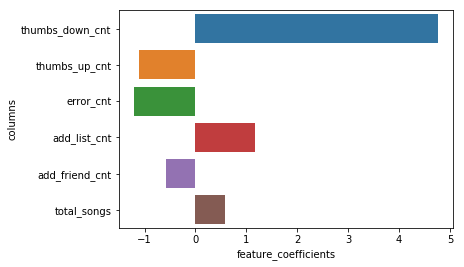

In [42]:
### logistic regression seems to have the best results
### now see the feature coefficients

feature_df = pd.DataFrame({'feature_coefficients' : model_lr.bestModel.stages[2].coefficients.values, 'columns':cols})
sns.barplot(x='feature_coefficients', y='columns', data=feature_df)

Logistic regression works the best with highest accuracy. And thumbs down count is the most influencial feature.

In [43]:
#Reference: https://stackoverflow.com/questions/38874546/spark-crossvalidatormodel-access-other-models-than-the-bestmodel/38874828#38874828
## model validation

import numpy as np

from pyspark.ml.tuning import CrossValidator, CrossValidatorModel
from pyspark.sql.functions import rand

class CrossValidatorVerbose(CrossValidator):

    def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)

        eva = self.getOrDefault(self.evaluator)
        metricName = eva.getMetricName()

        nFolds = self.getOrDefault(self.numFolds)
        seed = self.getOrDefault(self.seed)
        h = 1.0 / nFolds

        randCol = self.uid + "_rand"
        df = dataset.select("*", rand(seed).alias(randCol))
        metrics = [0.0] * numModels

        for i in range(nFolds):
            foldNum = i + 1
            print("Comparing models on fold %d" % foldNum)

            validateLB = i * h
            validateUB = (i + 1) * h
            condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
            validation = df.filter(condition)
            train = df.filter(~condition)

            for j in range(numModels):
                paramMap = epm[j]
                model = est.fit(train, paramMap)
                # TODO: duplicate evaluator to take extra params from input
                metric = eva.evaluate(model.transform(validation, paramMap))
                metrics[j] += metric

                avgSoFar = metrics[j] / foldNum
                print("params: %s\t%s: %f\tavg so far: %f" % (
                    {param.name: val for (param, val) in paramMap.items()},
                    metricName, metric, avgSoFar))

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)

        bestParams = epm[bestIndex]
        bestModel = est.fit(dataset, bestParams)
        avgMetrics = [m / nFolds for m in metrics]
        bestAvg = avgMetrics[bestIndex]
        print("Best model:\nparams: %s\t%s: %f" % (
            {param.name: val for (param, val) in bestParams.items()},
            metricName, bestAvg))

        return self._copyValues(CrossValidatorModel(bestModel, avgMetrics))

In [46]:
model = CrossValidatorVerbose(estimator=pipeline_lr,
                          estimatorParamMaps=paramgrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
model.fit(train_set)

Comparing models on fold 1
params: {'regParam': 0.0}	f1: 0.613578	avg so far: 0.613578
params: {'regParam': 0.1}	f1: 0.561887	avg so far: 0.561887
Comparing models on fold 2
params: {'regParam': 0.0}	f1: 0.678889	avg so far: 0.646234
params: {'regParam': 0.1}	f1: 0.605556	avg so far: 0.583721
Comparing models on fold 3
params: {'regParam': 0.0}	f1: 0.554622	avg so far: 0.615696
params: {'regParam': 0.1}	f1: 0.465546	avg so far: 0.544330
Best model:
params: {'regParam': 0.0}	f1: 0.615696


CrossValidatorModel_c75f6157a9ad

# Conclusion

Concluding this project...
- I've used apache spark application to clean up missing user id or session id
- using SQL syntax on top of spark, I performed data exploration on users churn
- With SQL query on spark, I extracted features for each user. And as for predicting churn, thumbs down count turned out to be more important

### more discussion

As for models, I think logistic regression worked the best for the small number of features and simplicity of the data.
Whether more features or models would be more efficient is left out for discussion.

I believe if such features as survey results for churned users, or user engagment time of the app, they would've been useful